In [1]:
import pandas as pd
import numpy as np
import dslabs_functions as dslabs
from matplotlib.pyplot import figure, show, subplots, plot, legend, savefig
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from sklearn.linear_model import LinearRegression
from sklearn.base import RegressorMixin


Index(['Total'], dtype='object')
Inferred frequency of the DateTimeIndex:  15T
Nr. Records =  2976
First timestamp 2023-10-01 00:00:00
Last timestamp 2023-10-31 23:45:00
-----
744
-----
186
-----
93
-----
31
-----
6
(2976, 1)
{'RMSE': [60.42407053527841, 57.947297688150634], 'MAE': [51.85260331831049, 49.35545887723025]} {'MAPE': [0.7143747094048871, 0.6947851019902733], 'R2': [5.273998601174057e-07, -0.001306433091169401]}
(2976,)
{'RMSE': [60.42407053527841, 57.947297688150634], 'MAE': [51.85260331831049, 49.35545887723025]} {'MAPE': [0.7143747094048871, 0.6947851019902733], 'R2': [5.273998601174057e-07, -0.001306433091169401]}


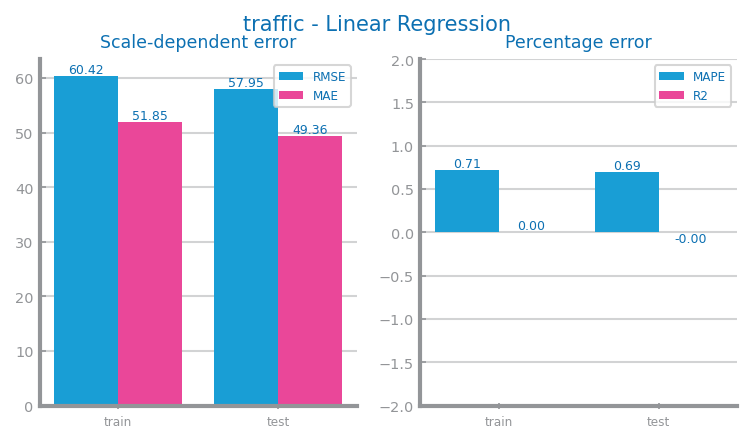

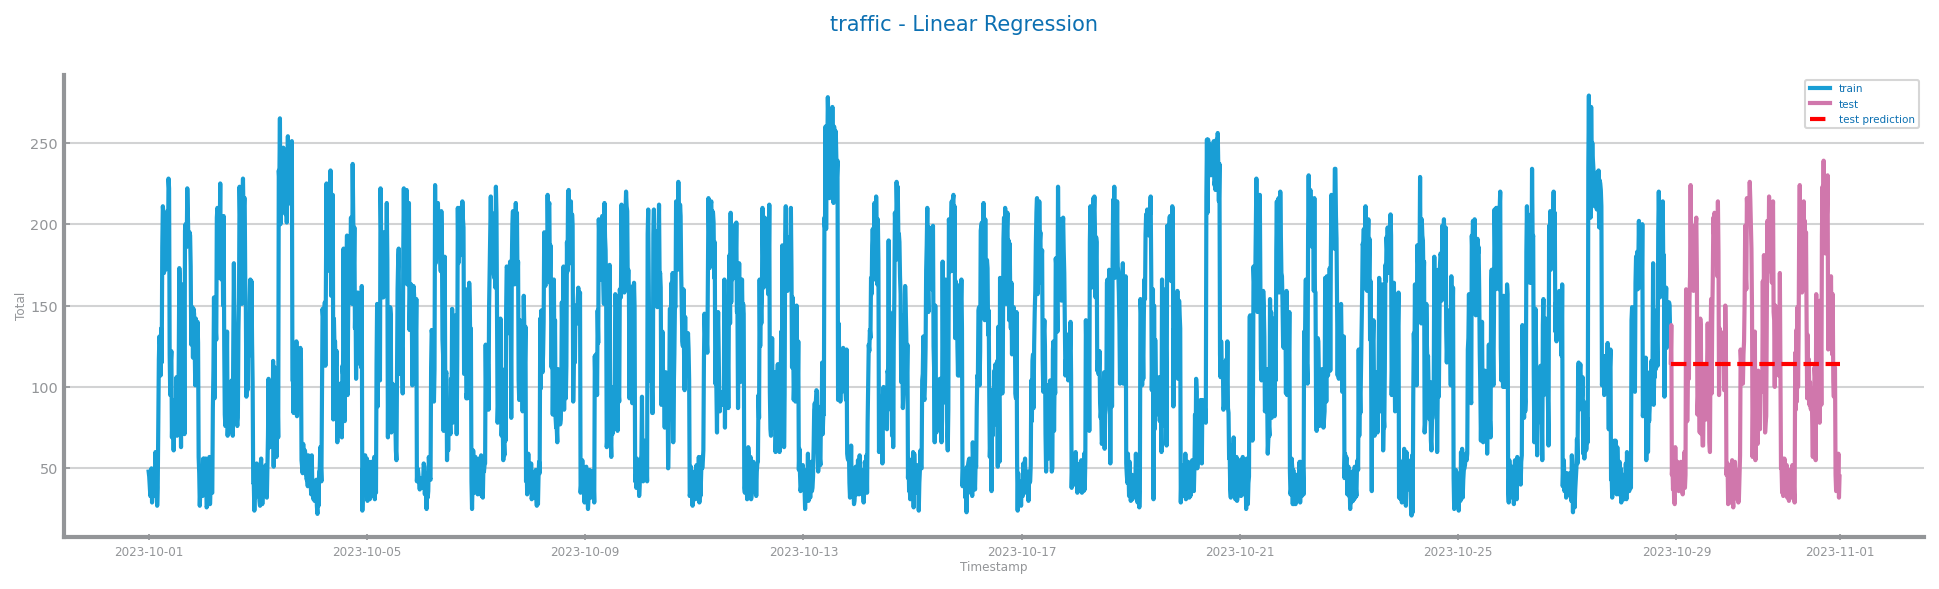

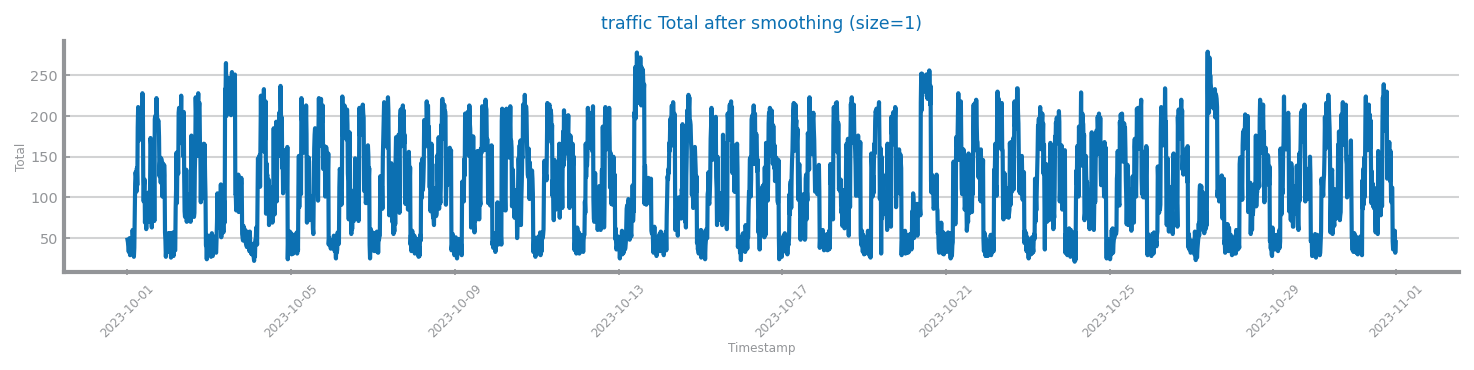

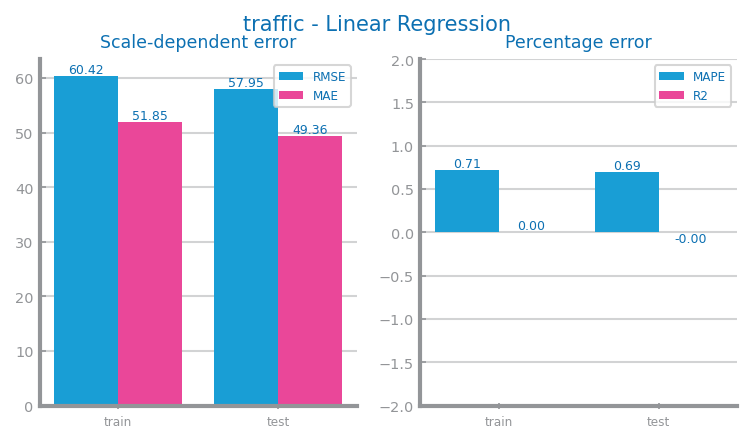

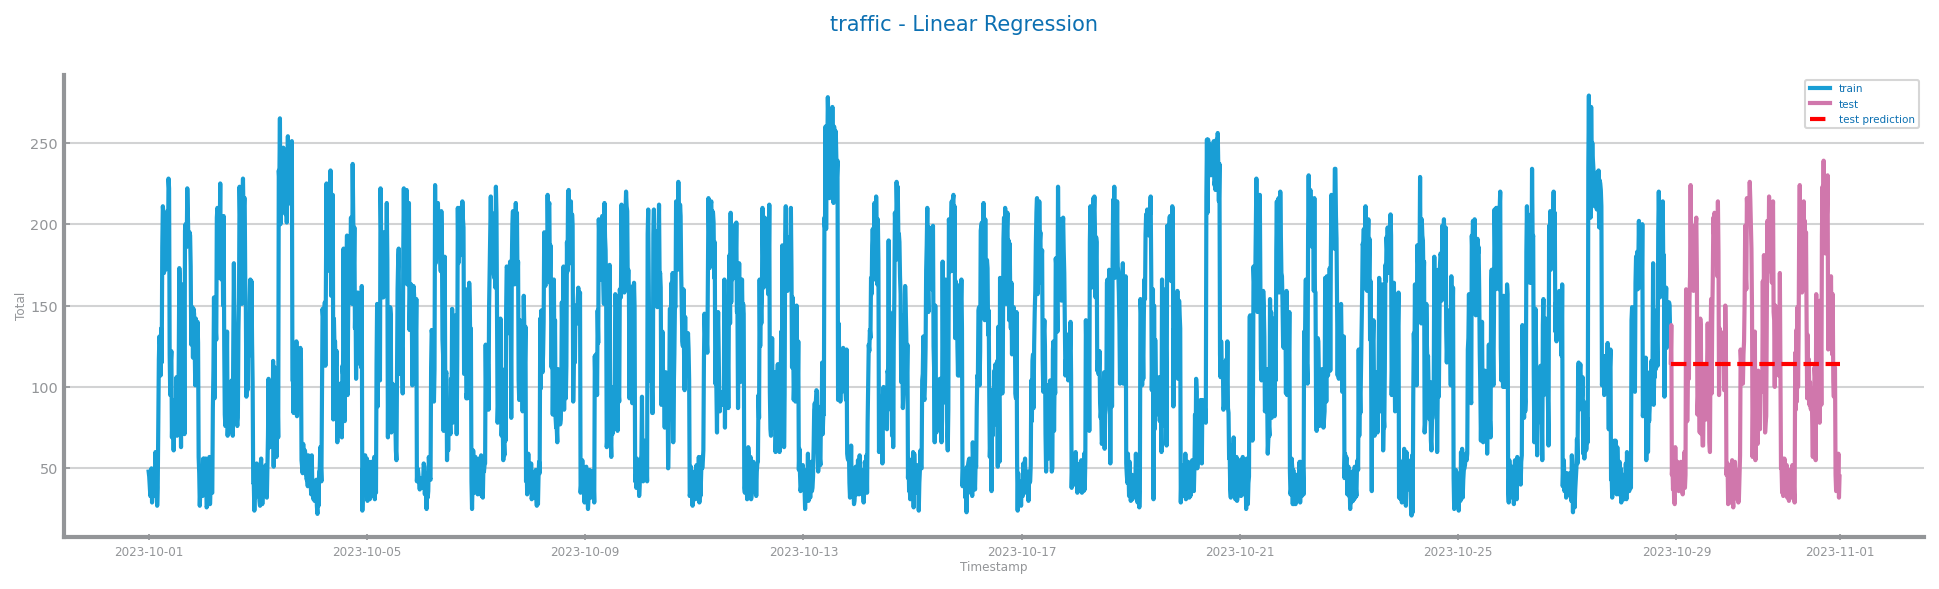

In [2]:
### Plotting UNIVARIATE Time Series
file_tag = "traffic"
target = "Total"
index="Timestamp"
### ordenar dados no csv ou nao e preciso??? last timestamp esta mal pq dados no csv nao estao ordenados por data
original_data: pd.DataFrame = pd.read_csv(
    "forecast_traffic_single.csv",
    index_col="Timestamp",
    sep=",",
    decimal=".",
    parse_dates=True,
    #infer_datetime_format=True,
)

print(original_data.columns)

### Sort 'TimeStamp' Ascending
original_data.sort_index(inplace=True)
#original_data.index = pd.to_datetime(original_data.index)
original_data.to_csv("sorted_forecast_traffic.csv")
series: pd.Series = original_data[target]
data = original_data.copy()
# Output the inferred frequency
inferred_freq = pd.infer_freq(series.index)
print("Inferred frequency of the DateTimeIndex: ", inferred_freq)

print("Nr. Records = ", series.shape[0])
print("First timestamp", series.index[0])
print("Last timestamp", series.index[-1])

# Aggregations

### Group by hour
ss_grouped_hour = dslabs.ts_aggregation_by(series, "H", "sum")
print("-----")
print(ss_grouped_hour.size)

### Group by 4-hour
grouped_sum_4 = []
indices = []
for j in range(0, len(original_data), 16):
    sum_value_4 = original_data.iloc[j:j+16]['Total'].sum()
    grouped_sum_4.append(sum_value_4)
    indices.append(original_data.index[j])
ss_grouped_4 = pd.Series(grouped_sum_4, index=indices)
print("-----")
print(ss_grouped_4.size)

### Group by 8-hour
grouped_sum_8 = []
indices = []
for j in range(0, len(original_data), 32):
    sum_value_8 = original_data.iloc[j:j+32]['Total'].sum()
    grouped_sum_8.append(sum_value_8)
    indices.append(original_data.index[j])
ss_grouped_8 = pd.Series(grouped_sum_8, index=indices)
print("-----")
print(ss_grouped_8.size)

### Group by Day and Week
ss_days = dslabs.ts_aggregation_by(series, "D", "sum")
print("-----")
print(ss_days.size)
ss_weeks = dslabs.ts_aggregation_by(series, "W", "sum")
print("-----")
print(ss_weeks.size)

### Plot and Results for Atomic Granularity (15Min)

train_1, test_1 = dslabs.series_train_test_split(original_data, trn_pct=0.90)
print(original_data.shape)
trnX_1 = np.arange(len(train_1)).reshape(-1, 1)
trnY_1 = train_1.to_numpy()

tstX_1 = np.arange(len(train_1), len(original_data)).reshape(-1, 1)
tstY_1 = test_1.to_numpy()

model = LinearRegression()
model.fit(trnX_1, trnY_1)

prd_trn: pd.Series = pd.Series(model.predict(trnX_1), index=train_1.index)
prd_tst: pd.Series = pd.Series(model.predict(tstX_1), index=test_1.index)

dslabs.plot_forecasting_eval(train_1, test_1, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")

dslabs.plot_forecasting_series(
    train_1,
    test_1,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)

## se usei funcao de soma para agregacao aqui uso media na mesma?
WIN_SIZE = 1
print(series.shape)
ss_smooth_atomic: pd.DataFrame = series.rolling(window=WIN_SIZE).mean()
ss_smooth_atomic.bfill(inplace=True)

figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT / 2))
dslabs.plot_line_chart(
    ss_smooth_atomic.index.to_list(),
    ss_smooth_atomic.to_list(),
    xlabel=ss_smooth_atomic.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after smoothing (size={WIN_SIZE})",
)

train_smooth, test_smooth = dslabs.dataframe_temporal_train_test_split(ss_smooth_atomic, trn_pct=0.90)

trnX_smooth = np.arange(len(train_smooth)).reshape(-1, 1)
trnY_smooth = train_smooth.to_numpy().ravel()

tstX_smooth = np.arange(len(train_smooth), len(ss_smooth_atomic)).reshape(-1, 1)
tstY_smooth = test_smooth.to_numpy().ravel()

model = LinearRegression()
model.fit(trnX_smooth, trnY_smooth)

prd_trn_smooth: pd.Series = pd.Series(model.predict(trnX_smooth), index=train_smooth.index)
prd_tst_smooth: pd.Series = pd.Series(model.predict(tstX_smooth), index=test_smooth.index)

dslabs.plot_forecasting_eval(train_smooth, test_smooth, prd_trn_smooth, prd_tst_smooth, title=f"{file_tag} - Linear Regression")

dslabs.plot_forecasting_series(
    train_smooth,
    test_smooth,
    prd_tst_smooth,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)
show()

(2976,)
ADF Statistic: -10.044
p-value: 0.000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series is stationary
{'RMSE': [34.12295286676192, 33.221726042527145], 'MAE': [24.396993529014175, 24.540706375413446]} {'MAPE': [2969173400038.3784, 3097169339720.952], 'R2': [8.568824286792065e-07, -6.068379161972004e-05]}


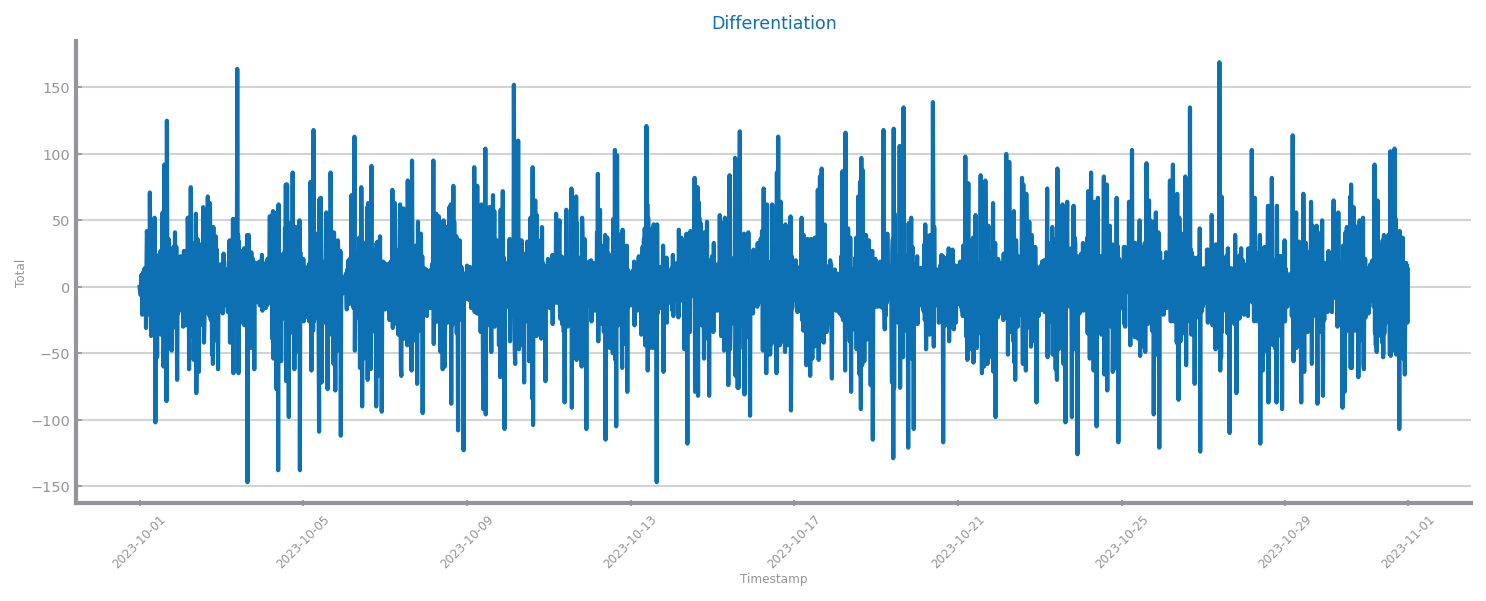

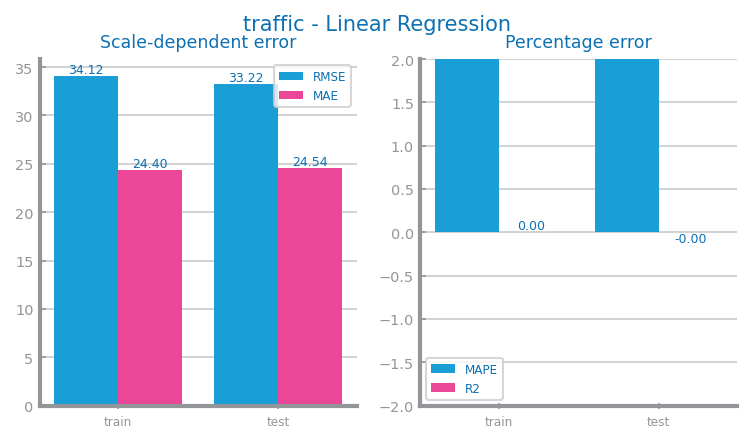

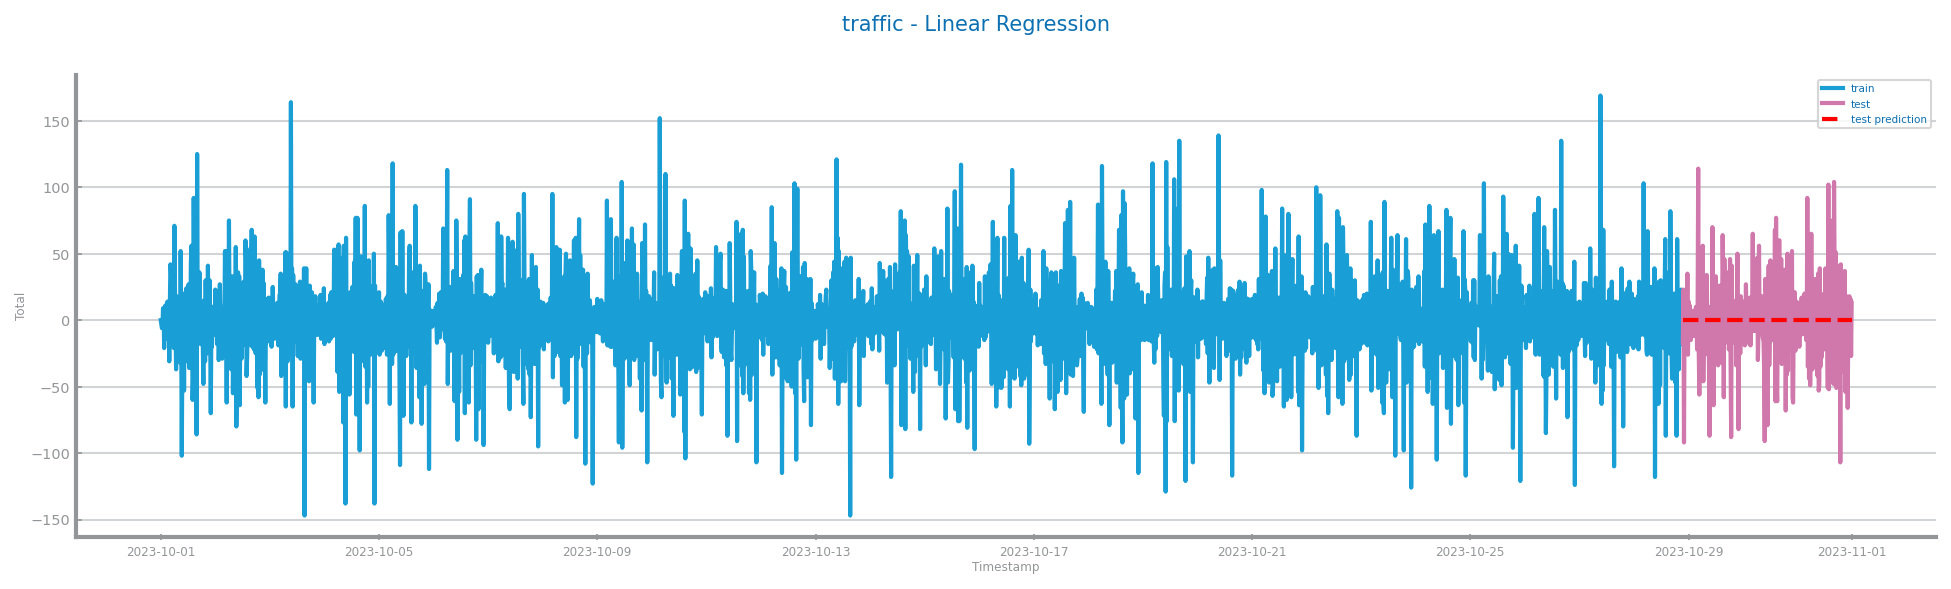

In [4]:
## First Differentiation
ss_diff: pd.Series = series.diff()
ss_diff[0] = 0
print(ss_diff.shape)
print(f"The series {('is' if dslabs.eval_stationarity(series) else 'is not')} stationary")
figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT))
dslabs.plot_line_chart(
    ss_diff.index.to_list(),
    ss_diff.to_list(),
    title="Differentiation",
    xlabel=series.index.name,
    ylabel=target,
)

train_diff, test_diff = dslabs.dataframe_temporal_train_test_split(ss_diff, trn_pct=0.90)

trnX_diff = np.arange(len(train_diff)).reshape(-1, 1)
trnY_diff = train_diff.to_numpy().ravel()

tstX_diff = np.arange(len(train_diff), len(ss_diff)).reshape(-1, 1)
tstY_diff = test_diff.to_numpy().ravel()

model = LinearRegression()
model.fit(trnX_diff, trnY_diff)

prd_trn_diff: pd.Series = pd.Series(model.predict(trnX_diff), index=train_diff.index)
prd_tst_diff: pd.Series = pd.Series(model.predict(tstX_diff), index=test_diff.index)

dslabs.plot_forecasting_eval(train_diff, test_diff, prd_trn_diff, prd_tst_diff, title=f"{file_tag} - Linear Regression")

dslabs.plot_forecasting_series(
    train_diff,
    test_diff,
    prd_tst_diff,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)
show()